<a href="https://colab.research.google.com/github/mehtamohit013/comms_lidar_ML/blob/main/BS_Selection/big_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab - Once per runtime

In [1]:
!nvidia-smi
!mkdir tb_logs

Mon Feb  7 11:50:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%%capture _
!unzip /gdrive/MyDrive/BTP/big_data/big_data.zip
# !unzip /gdrive/MyDrive/BTP/Webots_data/val_data.zip
!pip install pytorch-lightning

In [4]:
!pip install  --upgrade pandas

# Imports

In [5]:
%load_ext tensorboard

In [6]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from enum import Enum

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook
import os
import matplotlib.pyplot as plt
import random
import scipy.io as io
import math
import getpass
import time
from typing import Union

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

seed = 0

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
pl.seed_everything(seed)
torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = True #Use only while training, not while deterministic 

Global seed set to 0


# Hyper-params

In [7]:
user = getpass.getuser()

if user == 'root':  #For google colab
    data_dir = './data'
    save_dir = './model_state_dict'
elif user == 'mohit':
    data_dir = os.environ['HOME'] + '/webots_code/data/data'
    save_dir = os.path.join(os.environ['HOME'],'webots_code/model_state_dict/BD')
elif user == 'iiti':
    data_dir = os.environ['HOME'] + '/webots_code/comms_lidar_ML/data'
    save_dir = os.path.join(os.environ['HOME'],'webots_code/comms_lidar_ML/BS_Selection/model_state_dict')
else:
    print(f'User {user} not present.\n Exiting.....')
    exit(0)

os.makedirs(save_dir,exist_ok=True)

train_gps = pd.read_pickle(os.path.join(data_dir,'train.pkl')).reset_index(drop=True)
val_gps = pd.read_pickle(os.path.join(data_dir,'val.pkl')).reset_index(drop=True)
test_gps = pd.read_pickle(os.path.join(data_dir,'test.pkl')).reset_index(drop=True)

len_train = len(train_gps)
len_val = len(val_gps)
len_test = len(test_gps)


# lpath = data_dir
# labpath = os.path.join(data_dir,'labels')


len_train = len(train_gps)
len_val = len(val_gps)
len_test = len(test_gps)

BS = np.array([
    [38.89502,-77.07303,5],
    [38.89442,-77.07294,5],
    [38.89452,-77.07358,5]
])
num_BS = int(BS.shape[0])

BATCH_SIZE = 64

if (user=='root'):
    n_worker = 2
else:
    n_worker = 8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

cuda


# Utilities

In [8]:
def top_k_acc(y_true:torch.Tensor,y_pred:torch.Tensor,k=1):
    
    y_pred_tpk = torch.topk(y_pred,k,dim=1)[1]
    
    ovr = 0
    pos = 0

    for i in range(0,len(y_pred_tpk)):
        if(y_true[i] in y_pred_tpk[i]):
            pos+=1
        ovr+=1
    
    acc = float(pos)/float(ovr)
    return acc

# Creating Dataset and Dataloader

## Custom Dataset
Using 'GPS' currently.Translation can also be used instead of gps

In [9]:
class bs_dataset(Dataset):
    def __init__(self,gps_pd:pd.DataFrame):
    
        self.gps = gps_pd
        
    def __getitem__(self,index):
        filename = self.gps.at[index,'Folder'] + '/lidar_compressed/' + self.gps.at[index,'Lidar']
        sample = dict() 

        sample['lidar'] = dict(np.load(data_dir+'/' + self.gps.at[index,'Folder'] + '/lidar_compressed/' + self.gps.at[index,'Lidar']))['lidar'] #[10,240,240]
        sample['lidar'] = sample['lidar'].astype('float32')
        sample['gps'] = np.array(self.gps.at[index,'GPS'])[1].astype('float32') # Central GPS coord
        sample['BS'] = self.gps.at[index,'BS'].reshape((3*num_BS,)).astype('float32') #[num_BS*3,]
        sample['label'] = io.loadmat(data_dir +'/' + self.gps.at[index,'Folder'] + '/labels/' + self.gps.at[index,'Lidar'][:-3] +'mat')['ss']
        
        #Return the index of maximum element 
        sample['label'] = np.argmax(sample['label'].astype('float32')) 
        
        return sample
    
    def __len__(self):
        return len(self.gps)

In [10]:
train_dataset = bs_dataset(train_gps)
val_dataset = bs_dataset(val_gps)
test_dataset = bs_dataset(test_gps)

## Dataloader

In [11]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers = n_worker,
    drop_last = True,
    shuffle = True
    )

In [12]:
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers = n_worker,
    drop_last = True
    )

In [13]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers = n_worker,
    drop_last = True
)

# Models
Based on Imperial Model

## GPS Class

In [14]:
class gps_bs_sel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(12,16)
        self.linear2 = nn.Linear(16,32)
        self.linear3 = nn.Linear(32,64)
        self.linear4 = nn.Linear(64,32)
        self.linear5 = nn.Linear(32,16)
        self.linear6 = nn.Linear(16,8)
        self.linear7 = nn.Linear(8,3)
        
        self.relu = nn.ReLU()
    
    def forward(self,gps,BS):

        x = torch.cat([gps,BS],dim=1)
        
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        out = self.relu(out)
        out = self.linear4(out)
        out = self.relu(out)
        out = self.linear5(out)
        out = self.relu(out)
        out = self.linear6(out)
        out = self.relu(out)
        out = self.linear7(out)

        return out

In [15]:
class gps_no_bs(nn.Module):
    def __init__(self):
        super().__init__()

        self.ln1 = nn.Linear(3,8)
        self.ln2 = nn.Linear(8,16)
        self.ln3 = nn.Linear(16,8)
        self.ln4 = nn.Linear(8,3)

    def forward(self,x):
        x = F.prelu(self.ln1(x),torch.tensor(0.25).to(device))
        x = F.prelu(self.ln2(x),torch.tensor(0.25).to(device))
        x = F.prelu(self.ln3(x),torch.tensor(0.25).to(device))
        out = (self.ln4(x))

        return out

## Lidar Class

### NU Huskies
Resnet based architecture exploiting Residual connection


In [16]:
class NU(nn.Module):
    def __init__(self,drp:float=0.3,
                 drp_fc:float=0.2):
        super().__init__()
        self.drop_prob = drp
        self.drop = nn.Dropout(self.drop_prob)

        self.conv0 = nn.Sequential(nn.Conv2d(10,3,(3,3)),nn.ReLU())
        self.conv1 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.ReLU())
        self.conv3 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.ReLU())
        self.conv4 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.ReLU())
        self.conv5 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.ReLU())
        self.conv6 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.ReLU())
        self.conv7 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.ReLU())
        self.conv8 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.ReLU())

        self.m_pool1 = nn.MaxPool2d((2,2))
        self.m_pool2 = nn.MaxPool2d((1,2))

        self.flatten = nn.Flatten()

        self.drop_prob_fc = drp_fc
        self.drop_fc = nn.Dropout(self.drop_prob_fc)
        self.fc = nn.Sequential(nn.Linear(5400,512),
                                nn.ReLU(),
                                self.drop_fc,
                                nn.Linear(512,256),
                                nn.ReLU(),
                                self.drop_fc,
                                nn.Linear(256,3)
                                )
        
    def forward(self,X):
        a = X = self.conv0(X)
        X = F.pad(X,(1,1,1,1))
        a = F.pad(a,(1,1,1,1))
        X = self.conv1(X)
        X = F.pad(X,(1,1,1,1))
        X = self.conv2(X)
        X = F.pad(X,(1,1,1,1))
        X = X+a
        X = self.m_pool1(X)


        b = X= self.drop(X)

        X = self.conv3(X)
        X = F.pad(X,(1,1,1,1))
        X = self.conv4(X)
        X = F.pad(X,(1,1,1,1))
        X = X+b
        X = self.m_pool1(X)

        c = X = self.drop(X)

        X = self.conv5(X)
        X = F.pad(X,(1,1,1,1))
        X = self.conv6(X)
        X = F.pad(X,(1,1,1,1))
        X = X + c
        X = self.m_pool2(X)
        
        d = X = self.drop(X)

        X = self.conv7(X)
        X = F.pad(X,(1,1,1,1))
        X = self.conv8(X)
        X = F.pad(X,(1,1,1,1))
        X = X + d

        out = self.flatten(X)
        out = self.fc(out)
        
        return out


### Imperial

Simple CNN based on imperial model

Adding dropout for reduction in overfitting

In [17]:
class imp_lidar(nn.Module):
    def __init__(self,drp:float=0.2,drp_fc:float=0.2):
        super().__init__()
        
        self.drop_CNN = nn.Dropout(drp)
        self.drop_fc = nn.Dropout(drp_fc)

        self.channels = 5
        self.fchannel = 3
        self.conv1 = nn.Conv2d(10,self.channels, 13, 1, 1)
        self.bn1 = nn.BatchNorm2d(self.channels)
        self.relu1 = nn.PReLU(num_parameters=self.channels)
        self.conv2 = nn.Conv2d(self.channels, self.channels, 13, 1, 1)
        self.bn2 = nn.BatchNorm2d(self.channels)
        self.relu2 = nn.PReLU(num_parameters=self.channels)
        self.conv3 = nn.Conv2d(self.channels, self.channels, 7, 2, 1)
        self.bn3 = nn.BatchNorm2d(self.channels)
        self.relu3 = nn.PReLU(num_parameters=self.channels)
        self.conv4 = nn.Conv2d(self.channels, self.channels, 7, 1, 1)
        self.bn4 = nn.BatchNorm2d(self.channels)
        self.relu4 = nn.PReLU(num_parameters=self.channels)
        self.conv5 = nn.Conv2d(self.channels, self.fchannel, 5, 2, 1)
        self.bn5 = nn.BatchNorm2d(self.fchannel)
        self.relu5 = nn.PReLU(num_parameters=self.fchannel)
        self.conv6 = nn.Conv2d(self.fchannel, 1, 5, (1, 2), 1)
        self.bn6 = nn.BatchNorm2d(1)
        self.relu6 = nn.PReLU(num_parameters=1)

        self.flatten = nn.Flatten()
        self.linear7 = nn.Linear(1225,256)
        self.relu7 = nn.ReLU()

        self.linear8 = nn.Linear(256,16)
        self.linear9 = nn.Linear(16,3)

    def forward(self,x):

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)

        x = self.drop_CNN(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn3(x)
      
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.bn3(x)

        x = self.drop_CNN(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.bn5(x)

        x = self.conv6(x)
        x = self.relu6(x)
        x = self.bn6(x)

        x = self.drop_CNN(x)

        x = self.flatten(x)
        x = self.linear7(x)
        x = self.relu7(x)
        x = self.drop_fc(x)

        x = self.linear8(x)
        x= self.relu7(x)
        x = self.drop_fc(x)
        
        out = self.linear9(x)

        return out


### Model 1
Resnet based architecture but with higher kernel size, inspired from the results of imp model

Reason : As data is sparse higher kernel size may enable better computation

Convolution Output size : [(W−K+2P)/S]+1

*   W is the input volume 
*   K is the Kernel size 
*   P is the padding 
*   S is the stride 


In [18]:
class m1(nn.Module):
    def __init__(self,drp:float=0.3,
                 drp_fc:float=0.2):
        super().__init__()
        self.drop_prob = drp
        self.drop = nn.Dropout(self.drop_prob)

        self.conv0 = nn.Sequential(nn.Conv2d(10,3,(13,13)),nn.BatchNorm2d(3),nn.PReLU(3))
        self.conv1 = nn.Sequential(nn.Conv2d(3,3,(11,11)),nn.BatchNorm2d(3),nn.PReLU(3))
        self.conv2 = nn.Sequential(nn.Conv2d(3,3,(11,11)),nn.BatchNorm2d(3),nn.PReLU(3))
        self.conv3 = nn.Sequential(nn.Conv2d(3,3,(7,7)),nn.BatchNorm2d(3),nn.PReLU(3))
        self.conv4 = nn.Sequential(nn.Conv2d(3,3,(7,7)),nn.BatchNorm2d(3),nn.PReLU(3))
        self.conv5 = nn.Sequential(nn.Conv2d(3,3,(5,5)),nn.BatchNorm2d(3),nn.PReLU(3))
        self.conv6 = nn.Sequential(nn.Conv2d(3,3,(5,5)),nn.BatchNorm2d(3),nn.PReLU(3))
        self.conv7 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.BatchNorm2d(3),nn.PReLU(3))
        self.conv8 = nn.Sequential(nn.Conv2d(3,3,(3,3)),nn.BatchNorm2d(3),nn.PReLU(3))

        self.m_pool1 = nn.MaxPool2d((2,2))
        self.m_pool2 = nn.MaxPool2d((1,2))

        self.flatten = nn.Flatten()

        self.drop_prob_fc = drp_fc
        self.drop_fc = nn.Dropout(self.drop_prob_fc)
        self.fc = nn.Sequential(nn.Linear(4788,512),
                                nn.PReLU(1),
                                self.drop_fc,
                                nn.Linear(512,256),
                                nn.PReLU(1),
                                self.drop_fc,
                                nn.Linear(256,3)
                                )
        
    def forward(self,X):
        a = X = self.conv0(X)

        X = self.conv1(X)
        X = F.pad(X,(5,5,5,5))
        X = self.conv2(X)
        X = F.pad(X,(5,5,5,5))
        X = X+a
        X = self.m_pool1(X)


        b = X= self.drop(X)

        X = self.conv3(X)
        X = F.pad(X,(3,3,3,3))
        X = self.conv4(X)
        X = F.pad(X,(3,3,3,3))
        X = X+b
        X = self.m_pool1(X)

        c = X = self.drop(X)

        X = self.conv5(X)
        X = F.pad(X,(2,2,2,2))
        X = self.conv6(X)
        X = F.pad(X,(2,2,2,2))
        X = X + c
        X = self.m_pool2(X)
        
        d = X = self.drop(X)

        X = self.conv7(X)
        X = F.pad(X,(1,1,1,1))
        X = self.conv8(X)
        X = F.pad(X,(1,1,1,1))
        X = X + d

        out = self.flatten(X)
        out = self.fc(out)
        
        return out

In [19]:
# tmp = m1()

In [20]:
# a = torch.rand(1,10,240,240)
# tmp(a)

### Inception based model

In [21]:
class incp(nn.Module):
    def __init__(self,drp:float=0.3,
                 drp_fc:float=0.2):
        super().__init__()
        
        self.drop_CNN = nn.Dropout(drp)
        self.drop_fc = nn.Dropout(drp_fc)
        self.mpool = nn.MaxPool2d((2,2))
        self.channels = 5
        self.fchannel = 3
        self.conv1 = self.create_conv(10,self.channels,13)
        self.conv2 = self.create_conv(self.channels,self.channels,13)
        self.conv3 = self.create_conv(self.channels,self.channels,7)
        self.conv4 = self.create_conv(self.channels,self.channels,7)

        # 1st Inception block
        self.in1 = nn.Sequential(
            self.create_conv(self.channels,self.fchannel,1),
            self.create_conv(self.fchannel,self.fchannel,3),
            self.create_conv(self.fchannel,self.fchannel,3)
        )
        self.in2 = nn.Sequential(
            self.create_conv(self.channels,self.fchannel,1),
            self.create_conv(self.fchannel,self.fchannel,3)
        )
        self.in3 = nn.Sequential(
            nn.MaxPool2d((3,3)),
            self.create_conv(self.channels,self.fchannel,1)
        )
        self.in4 = self.create_conv(self.channels,self.fchannel,1)

        # Second inception block
        self.in5 = nn.Sequential(
            self.create_conv(self.fchannel*4,self.fchannel,1),
            self.create_conv(self.fchannel,self.fchannel,3),
            self.create_conv(self.fchannel,self.fchannel,3)
        )
        self.in6 = nn.Sequential(
            self.create_conv(self.fchannel*4,self.fchannel,1),
            self.create_conv(self.fchannel,self.fchannel,3)
        )
        self.in7 = nn.Sequential(
            nn.MaxPool2d((3,3)),
            self.create_conv(self.fchannel*4,self.fchannel,1)
        )
        self.in8 = self.create_conv(self.fchannel*4,self.fchannel,1)

        self.conv5 = self.create_conv(self.fchannel*4,self.fchannel,7)
        self.conv6 = self.create_conv(self.fchannel,self.fchannel,7)

        self.conv7 = self.create_conv(self.fchannel,self.fchannel,3)
        self.conv8 = self.create_conv(self.fchannel,self.fchannel,3)
        
        self.flatten = nn.Flatten()

        # self.linear = nn.Sequential(
        #     nn.Linear(2352,256),
        #     nn.PReLU(1),
        #     nn.BatchNorm1d(256),
        #     self.drop_fc,
        #     nn.Linear(256,64),
        #     nn.PReLU(1),
        #     nn.BatchNorm1d(64),
        #     self.drop_fc,
        #     nn.Linear(64,16),
        #     nn.PReLU(1),
        #     nn.BatchNorm1d(16),
        #     self.drop_fc,
        #     nn.Linear(16,3)
        # )

        self.linear = nn.Sequential(
            nn.Linear(588,16),
            nn.PReLU(1),
            nn.BatchNorm1d(16),
            nn.Linear(16,3)
        )

    
    def forward(self,X):
        X  = self.conv1(X)
        X  = self.conv2(X)
        X = self.mpool(X)

        X = self.conv3(X)
        X = self.conv4(X)
        X = self.mpool(X)

        X = self.drop_CNN(X)

        a = self.in1(X)
        a = F.pad(a,[2,2,2,2])
        b = self.in2(X)
        b = F.pad(b,[1,1,1,1])
        c = self.in3(X)
        c = F.pad(c,[16,16,16,16])
        d = self.in4(X)

        X = torch.cat((a,b,c,d),1)

        X = self.drop_CNN(X)

        a = self.in5(X)
        a = F.pad(a,[2,2,2,2])
        b = self.in6(X)
        b = F.pad(b,[1,1,1,1])
        c = self.in7(X)
        c = F.pad(c,[16,16,16,16])
        d = self.in8(X)

        X = torch.cat((a,b,c,d),1)
        X = self.drop_CNN(X)

        X = self.conv5(X)
        X = self.conv6(X)

        X = self.mpool(X)

        X = self.drop_CNN(X)

        X = self.conv7(X)
        X = self.conv8(X)
        # print(X.shape)

        X = self.flatten(X)
        out = self.linear(X)

        return out
    
    def create_conv(self,in_layers:int,out_layers:int,kernel,stride:int=1,
                    padding:int=0) -> nn.Module :

        return nn.Sequential(
            nn.Conv2d(in_layers,out_layers,kernel,stride,padding),
            nn.PReLU(out_layers),
            nn.BatchNorm2d(out_layers)
        )

In [22]:
# tmp = incp()
# a = torch.rand(2,10,240,240)
# tmp(a)
# sum(p.numel() for p in tmp.parameters())

## Lidar + GPS Class

In [23]:
class bs_model(nn.Module):
    def __init__(self,drop_prob:float=0.0,
                 drop_prob_fc:float=0.0):
        super().__init__()
        self.drop_CNN = nn.Dropout(drop_prob)
        self.drop_fc = nn.Dropout(drop_prob_fc)
        self.mpool = nn.MaxPool2d((2,2))
        self.channels = 5
        self.fchannel = 3
        self.conv1 = self.create_conv(10,self.channels,13)
        self.conv2 = self.create_conv(self.channels,self.channels,13)
        self.conv3 = self.create_conv(self.channels,self.channels,7)
        self.conv4 = self.create_conv(self.channels,self.channels,7)

        # 1st Inception block
        self.in1 = nn.Sequential(
            self.create_conv(self.channels,self.fchannel,1),
            self.create_conv(self.fchannel,self.fchannel,3),
            self.create_conv(self.fchannel,self.fchannel,3)
        )
        self.in2 = nn.Sequential(
            self.create_conv(self.channels,self.fchannel,1),
            self.create_conv(self.fchannel,self.fchannel,3)
        )
        self.in3 = nn.Sequential(
            nn.MaxPool2d((3,3)),
            self.create_conv(self.channels,self.fchannel,1)
        )
        self.in4 = self.create_conv(self.channels,self.fchannel,1)

        # Second inception block
        self.in5 = nn.Sequential(
            self.create_conv(self.fchannel*4,self.fchannel,3),
            self.create_conv(self.fchannel,self.fchannel,3)
        )
        self.in6 = nn.Sequential(
            self.create_conv(self.fchannel*4,self.fchannel,3)
        )
        self.in7 = nn.Sequential(
            nn.MaxPool2d((3,3)),
            self.create_conv(self.fchannel*4,self.fchannel,1)
        )
        self.in8 = self.create_conv(self.fchannel*4,self.fchannel,1)

        self.conv5 = self.create_conv(self.fchannel*4,self.fchannel*4,7)
        self.conv6 = self.create_conv(self.fchannel*4,self.fchannel*4,7)

        self.conv7 = self.create_conv(self.fchannel*4,self.fchannel*4,3)
        self.conv8 = self.create_conv(self.fchannel*4,self.fchannel*4,3)
        
        self.flatten = nn.Flatten()

        self.lidar_linear = nn.Sequential(
                            nn.Linear(2352,256),
                            nn.PReLU(1),
                            nn.BatchNorm1d(256),
                            self.drop_fc,
                            nn.Linear(256,128),
                            nn.PReLU(1),
                            nn.BatchNorm1d(128),
                            self.drop_fc
        )
        
        self.coord_linear = nn.Sequential(
                            nn.Linear(3,8),
                            nn.PReLU(1),
                            nn.Linear(8,16),
                            nn.PReLU(1),
                            nn.Linear(16,8),
                            nn.PReLU(1),
                            nn.Linear(8,3),
                            nn.PReLU(1),
        )

        self.cat_linear = nn.Sequential(
                            nn.Linear(131,64),
                            nn.PReLU(1),
                            nn.BatchNorm1d(64),
                            self.drop_fc,
                            nn.Linear(64,16),
                            nn.PReLU(1),
                            nn.BatchNorm1d(16),
                            self.drop_fc,
                            nn.Linear(16,3)
        )



    def forward(self,X,gps,bs):

        # [X,gps,bs] = input

        X  = self.conv1(X)
        X  = self.conv2(X)
        X = self.mpool(X)

        X = self.conv3(X)
        X = self.conv4(X)
        X = self.mpool(X)

        X = self.drop_CNN(X)

        a = self.in1(X)
        a = F.pad(a,[2,2,2,2])
        b = self.in2(X)
        b = F.pad(b,[1,1,1,1])
        c = self.in3(X)
        c = F.pad(c,[16,16,16,16])
        d = self.in4(X)

        X = torch.cat((a,b,c,d),1)

        X = self.drop_CNN(X)

        a = self.in5(X)
        a = F.pad(a,[2,2,2,2])
        b = self.in6(X)
        b = F.pad(b,[1,1,1,1])
        c = self.in7(X)
        c = F.pad(c,[16,16,16,16])
        d = self.in8(X)

        X = torch.cat((a,b,c,d),1)
        X = self.drop_CNN(X)

        X = self.conv5(X)
        X = self.conv6(X)
        X = self.mpool(X)

        X = self.drop_CNN(X)

        X = self.conv7(X)
        X = self.conv8(X)

        X = self.flatten(X)
        X = self.lidar_linear(X)

        # coord = torch.cat((gps,bs),dim=1)
        coord = self.coord_linear(gps)
        
        out = torch.cat((X,coord),dim=1)
        out = self.cat_linear(out)
        return out

    def create_conv(self,in_layers:int,out_layers:int,kernel,stride:int=1,
                    padding:int=0) -> nn.Module :

        return nn.Sequential(
            nn.Conv2d(in_layers,out_layers,kernel,stride,padding),
            nn.PReLU(out_layers),
            nn.BatchNorm2d(out_layers)
        )

In [24]:
# # For testing model shape and size
# model = bs_model()
# lidar = torch.Tensor(2,10,240,240)
# gps = torch.Tensor(2,3)
# BS = torch.Tensor(2,9)
# print(sum(p.numel() for p in model.parameters()))
# model(lidar,gps,BS)

# Training
Using pytorch lightning

## GPS

### Lightning class

In [ ]:
class gps_trainer(pl.LightningModule):
    def __init__(self,mtype,learning_rate = 1e-3):

        '''
        mtype : 'bs','no_bs' 
        '''

        super().__init__()
        self.mtype = mtype

        if self.mtype=='bs':
            self.model = gps_bs_sel()
        else:
            self.model = gps_no_bs()

        self.celoss = nn.CrossEntropyLoss()
        self.lr = learning_rate

        self.train_acc = 0
        self.val_acc = 0
        self.test_acc = 0
    
    def forward(self,gps,BS):
        
        if self.mtype == 'bs':
            out = self.model(gps,BS)
        else:
            out = self.model(gps)

        return out
    
    def training_step(self,batch,batch_idx):
        gps = batch['gps'].float()
        BS = batch['BS'].float()
        label = batch['label'].long()
        
        yhat = self(gps,BS)
        
        loss = self.celoss(yhat,label)
        
        self.log('Train Loss',loss)
        
        return {'loss':loss,'pred':yhat.cpu().detach(),'label':label.cpu().detach()}
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(),self.lr)
        return opt
    
    def training_epoch_end(self,train_out):        
        len_out = len(train_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = train_out[i]['pred'] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = train_out[i]['label']

        # Calculating Avg loss
        avg_loss = torch.stack([x['loss'] for x in train_out]).mean()

        top1 = top_k_acc(y_true,y_pred,k=1)
        self.train_acc = top1

        self.logger.experiment.add_scalar('Loss-Train per epoch',avg_loss,self.current_epoch)
        self.logger.experiment.add_scalar('Train Accuracy',top1,self.current_epoch)

        print(f'Train accuracies is {top1}')

    def validation_step(self,batch,batch_idx):
        gps = batch['gps'].float()
        BS = batch['BS'].float()
        label = batch['label'].long()
        
        yhat = self.forward(gps,BS)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def validation_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        self.val_acc = top1

        self.logger.experiment.add_scalar('Validation Accuracy',top1,self.current_epoch)

        print(f'Validation accuracy is {top1}')
    
    def test_step(self,batch,batch_idx):
        gps = batch['gps'].float()
        BS = batch['BS'].float()
        label = batch['label'].long()
        
        yhat = self.forward(gps,BS)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def test_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        self.test_acc = top1

        self.logger.experiment.add_hparams(
            {
                'LR' : self.lr,
                'overall params' : sum(p.numel() for p in self.model.parameters())
            },
            {
                'hparam/test_acc' : self.test_acc,
                'hparam/train_acc' : self.train_acc,
                'hparam/val_acc' : self.val_acc
            }
        )

        print(f'Test accuracy is {top1}')

### Class object and trainer

In [ ]:
gps_model = gps_trainer(mtype='no_bs')

In [ ]:
logger = TensorBoardLogger("tb_logs", name="GPS",log_graph=True,default_hp_metric=False)
gps_pl_trainer = pl.Trainer(
                    gpus=1,
                    max_epochs = 20,
                    logger = logger,
                    deterministic = True,
                    auto_lr_find = False
                     )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
gps_pl_trainer.fit(gps_model,train_loader,val_loader)
gps_pl_trainer.test(gps_model,test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/iiti/anaconda3/envs/webots_ml/lib/python3.7/site-packages/pytorch_lightning/loggers/tensorboard.py:249: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  UserWarning,
Missing logger folder: tb_logs/GPS

  | Name   | Type             | Params
--------------------------------------------
0 | model  | gps_no_bs        | 339   
1 | celoss | CrossEntropyLoss | 0     
--------------------------------------------
339       Trainable params
0         Non-trainable params
339       Total params
0.001     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/home/iiti/anaconda3/envs/webots_ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/iiti/anaconda3/envs/webots_ml/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/iiti/anaconda3/envs/webots_ml/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/iiti/anaconda3/envs/webots_ml/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/iiti/anaconda3/envs/webots_ml/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/iiti/anaconda3/envs/webots_ml/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 289, in rebuild_storage_fd
    fd = df.detach()
  File "/home/iiti/anaconda3/envs/webots_ml/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File 

Testing: 100%|██████████| 20/20 [00:05<00:00,  6.60it/s]Test accuracy is 0.32109375
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/iiti/anaconda3/envs/webots_ml/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/iiti/anaconda3/envs/webots_ml/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/iiti/anaconda3/envs/webots_ml/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/iiti/anaconda3/envs/webots_ml/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/iiti/anaconda3/envs/webots_ml/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/iiti/anaconda3/envs/webots_ml/lib/python3.7/multiprocessing/queues.py", lin

[{}]

## Lidar

### Lightning Class

In [25]:
class lidar_trainer(pl.LightningModule):
    def __init__(self,use_model:str,
                 drop_prob:float = 0.3,
                 drop_prob_fc:float = 0.2,
                 learning_rate:float = 1e-3,
                 weight_decay:float = 0.0):
        
        '''
        use_model = 'NU','imp'
        '''

        self.drp = drop_prob
        self.drp_fc = drop_prob_fc

        super().__init__()
        if use_model == 'NU':
            self.model = NU(drp=drop_prob,drp_fc = drop_prob_fc)
        elif use_model == 'imp':
            self.model = imp_lidar(drp=drop_prob,drp_fc = drop_prob_fc)
        elif use_model == 'm1':
            self.model = m1(drp=drop_prob,drp_fc = drop_prob_fc)
        elif use_model == 'incp':
            self.model = incp(drp=drop_prob,drp_fc = drop_prob_fc)

        self.celoss = nn.CrossEntropyLoss()
        self.lr = learning_rate
        self.wd = weight_decay

        self.train_acc = 0
        self.val_acc = 0
        self.test_acc = 0

        self.example_input_array = torch.rand(1,10,240,240) # For logging graph
    
    def forward(self,lidar):
        out = self.model(lidar)
        return out
    
    def training_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        label = batch['label'].long()
        
        yhat = self(lidar)
        
        loss = self.celoss(yhat,label)
        
        self.log('Train Loss',loss)
        
        return {'loss':loss,'pred':yhat.cpu().detach(),'label':label.cpu().detach()}
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(),self.lr,
                               weight_decay=self.wd)
        return opt
    
    def training_epoch_end(self,train_out):        
        len_out = len(train_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = train_out[i]['pred'] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = train_out[i]['label']

        top1 = top_k_acc(y_true,y_pred,k=1)

        # Calculating Avg loss
        avg_loss = torch.stack([x['loss'] for x in train_out]).mean()
        
        self.logger.experiment.add_scalar('Loss-Train per epoch',avg_loss,self.current_epoch)
        self.logger.experiment.add_scalar('Train Accuracy',top1,self.current_epoch)

        self.train_acc = top1
        
        print(f'Train accuracies is {top1}')

    def validation_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        label = batch['label'].long()
        
        yhat = self.forward(lidar)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def validation_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        self.val_acc = top1

        self.logger.experiment.add_scalar('Validation Accuracy',top1,self.current_epoch)

        print(f'Validation accuracy is {top1}')
    
    def test_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        label = batch['label'].long()
        
        yhat = self.forward(lidar)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def test_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        self.test_acc = top1

        self.logger.experiment.add_hparams(
            {
                'LR' : self.lr,
                'weight_decay' : self.wd,
                'drop_prob' : self.drp,
                'drop_fc' : self.drp_fc,
                'overall params' : sum(p.numel() for p in self.model.parameters())
            },
            {
                'hparam/test_acc' : self.test_acc,
                'hparam/train_acc' : self.train_acc,
                'hparam/val_acc' : self.val_acc
            }
        )
        print(f'Test accuracy is {top1}')

### Class object and trainer

In [26]:
lidar_model = lidar_trainer(use_model='incp',drop_prob=0.3,drop_prob_fc=0.2,weight_decay=1e-4,learning_rate=3.63e-4)

In [27]:
logger = TensorBoardLogger("tb_logs_BD", name="inception",log_graph=True,default_hp_metric=False)
lidar_pl_trainer = pl.Trainer(
                     gpus=1,
                     max_epochs = 20,
                     precision = 16,
                     logger = logger,
                     amp_backend = 'native',
                     deterministic = True,
                     auto_lr_find = False
                     )

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [28]:
# lidar_pl_trainer.tune(lidar_model,train_loader,val_loader)
lidar_pl_trainer.fit(lidar_model,train_loader,val_loader)
lidar_pl_trainer.test(lidar_model,test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  if hasattr(mod, name):

  | Name   | Type             | Params | In sizes          | Out sizes
----------------------------------------------------------------------------
0 | model  | incp             | 28.0 K | [1, 10, 240, 240] | [1, 3]   
1 | celoss | CrossEntropyLoss | 0      | ?                 | ?        
----------------------------------------------------------------------------
28.0 K    Trainable params
0         Non-trainable params
28.0 K    Total params
0.056     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 0


Validation accuracy is 0.3046875


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.436820652173913
Train accuracies is 0.5133411319073083


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Test accuracy is 0.4453125
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

[{}]

In [29]:
lidar_pl_trainer.save_checkpoint('lidar_final.ckpt')

## Lidar + GPS

### Lightning Class

In [ ]:
class BS_trainer(pl.LightningModule):
    def __init__(self,drop_prob:float = 0.3,
                 drop_prob_fc:float = 0.2,
                 learning_rate:float = 1e-3,
                 weight_decay:float = 0.0):
        
        super().__init__()

        self.drp = drop_prob
        self.drp_fc = drop_prob_fc
        self.lr = learning_rate
        self.wd = weight_decay

        self.model = bs_model(self.drp,self.drp_fc)
        self.celoss = nn.CrossEntropyLoss()

        self.train_acc = 0
        self.val_acc = 0
        self.test_acc = 0

        self.example_input_array = [torch.rand(1,10,240,240),torch.rand(1,3),torch.rand(1,9)] # For logging graph
    
    def forward(self,lidar,gps,BS):
        out = self.model(lidar,gps,BS)
        return out
    
    def training_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        gps = batch['gps'].float()
        BS = batch['BS'].float()
        label = batch['label'].long()
        
        yhat = self(lidar,gps,BS)
        
        loss = self.celoss(yhat,label)
        
        self.log('Train Loss',loss)
        
        return {'loss':loss,'pred':yhat.cpu().detach(),'label':label.cpu().detach()}
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(),self.lr,weight_decay=self.wd)
        return opt
    
    def training_epoch_end(self,train_out):        
        len_out = len(train_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = train_out[i]['pred'] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = train_out[i]['label']

        # Calculating Avg loss
        avg_loss = torch.stack([x['loss'] for x in train_out]).mean()

        top1 = top_k_acc(y_true,y_pred,k=1)
        self.train_acc = top1

        self.logger.experiment.add_scalar('Loss-Train per epoch',avg_loss,self.current_epoch)
        self.logger.experiment.add_scalar('Train Accuracy',top1,self.current_epoch)

        print(f'Train accuracies is {top1}')

    def validation_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        gps = batch['gps'].float()
        BS = batch['BS'].float()
        label = batch['label'].long()
        
        yhat = self.forward(lidar,gps,BS)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def validation_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        self.val_acc = top1

        self.logger.experiment.add_scalar('Validation Accuracy',top1,self.current_epoch)
        print(f'Validation accuracy is {top1}')
    
    def test_step(self,batch,batch_idx):
        lidar = batch['lidar'].float()
        gps = batch['gps'].float()
        BS = batch['BS'].float()
        label = batch['label'].long()
        
        yhat = self.forward(lidar,gps,BS)
        
        return [yhat.cpu().detach(),label.cpu().detach()]
     
    def test_epoch_end(self,val_out):
        len_out = len(val_out)
        y_pred = torch.Tensor(len_out*BATCH_SIZE,num_BS)
        y_true = torch.Tensor(len_out*BATCH_SIZE)

        for i in range(0,len_out):
            y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = val_out[i][0] 
            y_true[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = val_out[i][1] 

        top1 = top_k_acc(y_true,y_pred,k=1)
        self.test_acc = top1

        self.logger.experiment.add_hparams(
            {
                'LR' : self.lr,
                'weight_decay' : self.wd,
                'drop_prob' : self.drp,
                'drop_fc' : self.drp_fc,
                'overall params' : sum(p.numel() for p in self.model.parameters())
            },
            {
                'hparam/test_acc' : self.test_acc,
                'hparam/train_acc' : self.train_acc,
                'hparam/val_acc' : self.val_acc
            }
        )
        print(f'Test accuracy is {top1}')

### Class object and trainer 

In [ ]:
model = BS_trainer(drop_prob=0.3,drop_prob_fc=0.2,weight_decay=1e-4,learning_rate = 5.25e-4)

In [ ]:
logger = TensorBoardLogger("tb_logs", name="lidar_gps",log_graph=True,default_hp_metric=False)
lidar_gps_pl_trainer =  pl.Trainer(
                     gpus=1,
                     max_epochs = 20,
                     precision = 16,
                     logger = logger,
                     amp_backend = 'native',
                     auto_lr_find = False,
                     deterministic = True
                     )

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
lidar_gps_pl_trainer.tune(model,train_loader,val_loader)
lidar_gps_pl_trainer.fit(model,train_loader,val_loader)
lidar_gps_pl_trainer.test(model,test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type             | Params | In sizes                            | Out sizes
----------------------------------------------------------------------------------------------
0 | model  | bs_model         | 679 K  | [[1, 10, 240, 240], [1, 3], [1, 9]] | [1, 3]   
1 | celoss | CrossEntropyLoss | 0      | ?                                   | ?        
----------------------------------------------------------------------------------------------
679 K     Trainable params
0         Non-trainable params
679 K     Total params
2.718     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 0


Validation accuracy is 0.3046875


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.469429347826087
Train accuracies is 0.5159574468085106


Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.46875
Train accuracies is 0.5841090425531915


Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.5618206521739131
Train accuracies is 0.6018949468085106


Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.578125
Train accuracies is 0.6192652925531915


Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.5855978260869565
Train accuracies is 0.6259142287234043


Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.5985054347826086
Train accuracies is 0.63671875


Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.6134510869565217
Train accuracies is 0.6431183510638298


Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.6345108695652174
Train accuracies is 0.65234375


Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.6290760869565217
Train accuracies is 0.655501994680851


Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.6372282608695652
Train accuracies is 0.6652260638297872


Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.6399456521739131
Train accuracies is 0.6673869680851063


Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.6474184782608695
Train accuracies is 0.6772772606382979


Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.641983695652174
Train accuracies is 0.6786901595744681


Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.6440217391304348
Train accuracies is 0.6851728723404256


Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.6399456521739131
Train accuracies is 0.6949800531914894


Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.6589673913043478
Train accuracies is 0.6938164893617021


Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.654891304347826
Train accuracies is 0.7057845744680851


Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.6521739130434783
Train accuracies is 0.7121841755319149


Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.6277173913043478
Train accuracies is 0.7076130319148937


Validating: 0it [00:00, ?it/s]

Validation accuracy is 0.6399456521739131


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train accuracies is 0.7233211436170213


Testing: 0it [00:00, ?it/s]

Test accuracy is 0.63828125
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

# Accuracy based on distance

In [ ]:
def dist_gps(gps1, gps2):
    lat1, lon1, _ = gps1
    lat2, lon2, _ = gps2
    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + \
        math.cos(phi_1) * math.cos(phi_2) * \
        math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c


In [ ]:
y_pred = list()
pos = 0
ovr = 0 
for i in range(0,len_train):
    data = train_dataset[i]
    dist1 = dist_gps(data['gps'],data['BS'][:3])
    dist2 = dist_gps(data['gps'],data['BS'][3:6])
    dist3 = dist_gps(data['gps'],data['BS'][6:9])

    # print(dist1,dist2,dist3)
    
    index = np.argmax(np.array([dist1,dist2,dist3]))

    # print(index,data['label'])

    if index == data['label']:
        pos+=1
    ovr+=1
    # if((i+1)%10==0):
    #     break
print(f'Accuracy based on shortest distance on train is {pos/ovr}')

Accuracy based on shortest distance on train is 0.2686220896511724


In [ ]:
y_pred = list()
pos = 0
ovr = 0 
for i in range(0,len_val):
    data = val_dataset[i]
    dist1 = dist_gps(data['gps'],data['BS'][:3])
    dist2 = dist_gps(data['gps'],data['BS'][3:6])
    dist3 = dist_gps(data['gps'],data['BS'][6:9])

    # print(dist1,dist2,dist3)
    
    index = np.argmax(np.array([dist1,dist2,dist3]))

    # print(index,data['label'])

    if index == data['label']:
        pos+=1
    ovr+=1
    # if((i+1)%10==0):
    #     break
print(f'Accuracy based on shortest distance on val is {pos/ovr}')

Accuracy based on shortest distance on val is 0.27095908786049633


# Federated Learning (FedAvg)

Without retraining on baseline data on global server [link](https://towardsdatascience.com/preserving-data-privacy-in-deep-learning-part-3-ae2103c40c22)

## Hyper-params (For federated)

In [ ]:
epoch_round = 2 # Number of epochs per dataset
cm_rounds = 10 #Overall communication round

torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = True #Use only while training, not while deterministic 

# Available option : 'mean','wmean'
agg = 'mean' 
# Possible model_type: 'lg' : lidar + GPS,'l' : lidar,'g' : Gps 
model_type = 'l'

## Parameters

 Calculating number of cars

In [ ]:
def cars_dist(data_pd:pd.DataFrame) -> list:
    car_list = list()
    car_sample = dict()
    for i in range(0,len_train):
        if not(data_pd.at[i,'Name'] in car_list):
            car_list.append(data_pd.at[i,'Name'])
            car_sample[int(data_pd.at[i,'Name'][-2:])] = list()
        car_sample[int(data_pd.at[i,'Name'][-2:])].append(i)

    return car_sample, car_list
    

In [ ]:
train_car_sample,train_car_list = cars_dist(train_gps)

Plotting number of samples per car

<BarContainer object of 57 artists>

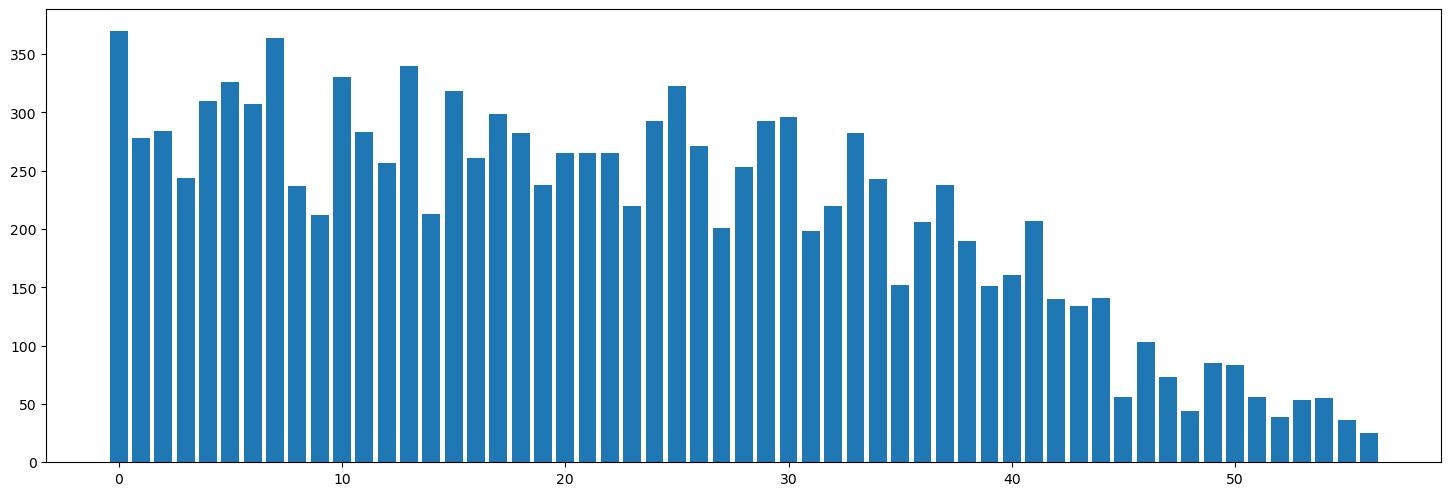

In [ ]:
plt.rcParams['figure.figsize'] = [18, 6]
plt.rcParams['figure.dpi'] = 100 
len_car = [len(train_car_sample[i]) for i in range(0,len(train_car_list))]
plt.bar(range(0,len(train_car_list)),len_car)

## Creating Dataset and Dataloaders

### Dataset

In [ ]:
cl_dataset = list()

for i in train_car_list:
    tmp = bs_dataset(train_gps[train_gps['Name']==i].reset_index(drop=True))
    cl_dataset.append(tmp)

### Dataloader

In [ ]:
cl_loader = list()

for i in range(0,len(cl_dataset)):
    tmp = DataLoader(
        cl_dataset[i],
        batch_size=BATCH_SIZE,
        pin_memory=True,
        num_workers = n_worker,
        drop_last = True,
        shuffle = True
        )
    cl_loader.append(tmp)

## Model

### Client update

In [ ]:
class client():
    
    '''
    Currently using standard trainer to train the model 
    '''
    def __init__(self,model:nn.Module,
                loader:DataLoader,
                epoch:int = epoch_round,
                model_type:str=model_type,
                wd=1e-4,lr=1e-3):
    
        self.model = model.to(device)
        self.loader = loader
        self.epoch = epoch
        self.model_type = model_type

        self.lr = lr
        self.wd = wd
        self.celoss = nn.CrossEntropyLoss()
        self.opt = torch.optim.Adam(model.parameters(),self.lr,weight_decay=self.wd)
        self.start = time.time()

    def train(self):

        self.model.train()
        self.model.zero_grad()

        for i in range(0,self.epoch):

            # print('-'*10+f' Starting Epoch {i+1} '+'-'*10)
            
            running_loss = 0.0
            running_acc = 0.000
            
            for count,batch in enumerate(self.loader):

                self.opt.zero_grad()

                lidar = batch['lidar'].float().to(device)
                gps = batch['gps'].float().to(device)
                BS = batch['BS'].float().to(device)
                label = batch['label'].long().to(device)

                if self.model_type == 'lg':
                    yhat = self.model(lidar,gps,BS)
                elif self.model_type == 'l':
                    yhat = self.model(lidar)
                else:
                    yhat = self.model(gps,BS)
                
                loss = self.celoss(yhat,label)
                running_loss +=loss.item()
                
                loss.backward()
                self.opt.step()

                top1 = top_k_acc(label.cpu().detach(),yhat.cpu().detach(),k=1)
                running_acc = (running_acc*(count)*BATCH_SIZE + top1*BATCH_SIZE)/ ((count+1)*BATCH_SIZE)

                # if count%1000 == 0 :
                #     print(f'Cross Entropy loss after {count} iterations is {running_loss/((count+1)*BATCH_SIZE)}. '\
                #           f'Time Elapsed {time.time()-self.start}')
                #     print(f'Accuracy on train after {count} iteration is {running_acc}')
            
            # print(f'Overall iteration completed {count}') #304
            # print('-'*10+f' Epoch {i+1} ends '+'-'*10)
            # print(f'Cross Entropy loss after {i+1} epochs is {running_loss/((count+1)*BATCH_SIZE)}'\
            #       f'Time Elapsed {time.time()-self.start}')
            # print(f'Accuracy on train after {i+1} epochs is {running_acc}')

### Global Server

In [ ]:
class fed_server():
    def __init__(self,cars:int,cl_dataset,cl_loader,agg:str=agg,
                model_type:str=model_type,ovr_sample:int=len_train,
                val_loader:DataLoader=val_loader,
                train_loader:DataLoader=train_loader,
                test_loader:DataLoader = test_loader,
                wd:float = 1e-4,lr:float=1e-4):
        
        self.cars = cars
        self.dataset = cl_dataset
        self.loader = cl_loader
        self.agg = agg
        self.model_type = model_type
        self.ovr_sample = ovr_sample
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.lr = lr

        self.writer = SummaryWriter(log_dir =f'./tb_logs_new2/federated/{self.model_type}',
                                    comment=self.model_type)

        self.wd = wd
        self.celoss = nn.CrossEntropyLoss()

        self.create_model() #Global Model
    
    def create_model(self):
        if self.model_type == 'lg':
            self.model = bs_model(0.3,0.2).to(device)
            self.lr = 5.25e-4
            self.sample_input = [torch.rand((2,10,240,240)).to(device),torch.rand((2,9)).to(device),torch.rand((2,9)).to(device)]
        elif self.model_type == 'l':
            self.model = incp(0.3,0.2).to(device)
            self.lr = 3.63e-4
            self.sample_input = torch.rand((2,10,240,240)).to(device)
        else:
            self.model = gps_bs_sel().to(device)
            self.sample_input = [torch.rand((2,3)).to(device),torch.rand((2,9)).to(device)]
        self.writer.add_graph(self.model,self.sample_input)
    
    def per_round(self,epoch):

        #Synchronizing client model with global model at start of each round
        cl_model = [self.model for i in range(0,self.cars)]
        for cmodel in cl_model:
            cmodel.load_state_dict(self.model.state_dict())


        # Training Client Model
        for i in tqdm_notebook(range(0,self.cars),desc='Cars'):
            # print('*'*3+f' Starting Client {i} ' +'*'*3)
            
            if not(len(self.loader[i])) :
                # print(f'Not enough samples for client {i}')
                cl_model[i].load_state_dict(self.model.state_dict())
                continue

            tmp = client(cl_model[i],self.loader[i],epoch,self.model_type,wd=self.wd,lr=self.lr)
            tmp.train()

        # Global aggregration
        global_dict = self.model.state_dict()

        for k in global_dict.keys():
            if self.agg == 'mean':
                
                global_dict[k] = torch.stack([cl_model[i].state_dict()[k].float() 
                                            for i in range(len(cl_model))], 0).mean(0)
            
            else:
                global_dict[k] = torch.sum(
                                        torch.stack([cl_model[i].state_dict()[k].float()*(float(len(cl_dataset[i]))/float(self.ovr_sample)) 
                                        for i in range(len(cl_model))], 0),
                                        0)
        
        self.model.load_state_dict(global_dict)
        print('Global Aggregration Successfull')
    
    def train(self,cm_rounds:int=cm_rounds,epoch_round:int=epoch_round):

        for i in tqdm_notebook(range(0,cm_rounds),desc='Rounds'):
            
            # print('-'*10+f' Staring round {i+1} '+ '-'*10)
            self.per_round(epoch_round)

            print('#'*3 + 'Train Accuracy '+ '#'*3)
            self.train_acc(i)
            
            print('#'*3 + 'Validation Accuracy '+ '#'*3)
            self.val(i)

    def train_acc(self,epoch:int):
        self.model.eval()
        running_loss = 0.0
        running_acc = 0.000
        running_loss = 0.0

        for count,batch in tqdm_notebook(enumerate(self.train_loader),desc='Train Metrics',
                                         total=len(self.train_loader)):

            lidar = batch['lidar'].float().to(device)
            gps = batch['gps'].float().to(device)
            BS = batch['BS'].float().to(device)
            label = batch['label'].long().to(device)

            if self.model_type == 'lg':
                yhat = self.model(lidar,gps,BS)
            elif self.model_type == 'l':
                yhat = self.model(lidar)
            else:
                yhat = self.model(gps,BS)

            loss = self.celoss(yhat,label)
            running_loss += loss.item()
            top1 = top_k_acc(label.cpu().detach(),yhat.cpu().detach(),k=1)
            running_acc = (running_acc*(count)*BATCH_SIZE + top1*BATCH_SIZE)/ ((count+1)*BATCH_SIZE)
        
        running_loss = running_loss/((count+1)*BATCH_SIZE)
        self.writer.add_scalar('Train Acc',running_acc,epoch)
        self.writer.add_scalar('Avg Train Loss per round',running_loss,epoch)
        print(f'Accuracy on train is {running_acc}')
    
    def val(self,epoch:int):

        self.model.eval()
        running_loss = 0.0
        running_acc = 0.000

        for count,batch in tqdm_notebook(enumerate(self.val_loader),desc='Val Metrics',
                                         total=len(self.val_loader)):

            lidar = batch['lidar'].float().to(device)
            gps = batch['gps'].float().to(device)
            BS = batch['BS'].float().to(device)
            label = batch['label'].long().to(device)

            if self.model_type == 'lg':
                yhat = self.model(lidar,gps,BS)
            elif self.model_type == 'l':
                yhat = self.model(lidar)
            else:
                yhat = self.model(gps,BS)

            top1 = top_k_acc(label.cpu().detach(),yhat.cpu().detach(),k=1)
            running_acc = (running_acc*(count)*BATCH_SIZE + top1*BATCH_SIZE)/ ((count+1)*BATCH_SIZE)
        
        self.writer.add_scalar('Val Acc',running_acc,epoch)
        print(f'Accuracy on val is {running_acc}')
    
    def test(self):
        self.model.eval()
        running_loss = 0.0
        running_acc = 0.000

        for count,batch in tqdm_notebook(enumerate(self.test_loader),desc='Test Metrics'):

            lidar = batch['lidar'].float().to(device)
            gps = batch['gps'].float().to(device)
            BS = batch['BS'].float().to(device)
            label = batch['label'].long().to(device)

            if self.model_type == 'lg':
                yhat = self.model(lidar,gps,BS)
            elif self.model_type == 'l':
                yhat = self.model(lidar)
            else:
                yhat = self.model(gps,BS)

            top1 = top_k_acc(label.cpu().detach(),yhat.cpu().detach(),k=1)
            running_acc = (running_acc*(count)*BATCH_SIZE + top1*BATCH_SIZE)/ ((count+1)*BATCH_SIZE)
        
        self.writer.add_scalar('Test Acc',running_acc,0)
        print(f'Accuracy on Test is {running_acc}')


## Training - Federated Learning

In [ ]:
federated = fed_server(len(train_car_list),cl_dataset,cl_loader,agg,
                       model_type,len_train,val_loader,train_loader,test_loader,wd=1e-4)

In [ ]:
federated.train(cm_rounds,epoch_round)

Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

Cars:   0%|          | 0/57 [00:00<?, ?it/s]

Global Aggregration Successfull
###Train Accuracy ###


Train Metrics:   0%|          | 0/188 [00:00<?, ?it/s]

Accuracy on train is 0.516456117021277
###Validation Accuracy ###


Val Metrics:   0%|          | 0/23 [00:00<?, ?it/s]

Accuracy on val is 0.5163043478260869


Cars:   0%|          | 0/57 [00:00<?, ?it/s]

Global Aggregration Successfull
###Train Accuracy ###


Train Metrics:   0%|          | 0/188 [00:00<?, ?it/s]

Accuracy on train is 0.559175531914894
###Validation Accuracy ###


Val Metrics:   0%|          | 0/23 [00:00<?, ?it/s]

Accuracy on val is 0.5455163043478262


Cars:   0%|          | 0/57 [00:00<?, ?it/s]

Global Aggregration Successfull
###Train Accuracy ###


Train Metrics:   0%|          | 0/188 [00:00<?, ?it/s]

Accuracy on train is 0.5686502659574466
###Validation Accuracy ###


Val Metrics:   0%|          | 0/23 [00:00<?, ?it/s]

Accuracy on val is 0.5645380434782609


Cars:   0%|          | 0/57 [00:00<?, ?it/s]

Global Aggregration Successfull
###Train Accuracy ###


Train Metrics:   0%|          | 0/188 [00:00<?, ?it/s]

Accuracy on train is 0.5749667553191492
###Validation Accuracy ###


Val Metrics:   0%|          | 0/23 [00:00<?, ?it/s]

Accuracy on val is 0.5706521739130435


Cars:   0%|          | 0/57 [00:00<?, ?it/s]

Global Aggregration Successfull
###Train Accuracy ###


Train Metrics:   0%|          | 0/188 [00:00<?, ?it/s]

Accuracy on train is 0.5713929521276601
###Validation Accuracy ###


Val Metrics:   0%|          | 0/23 [00:00<?, ?it/s]

Accuracy on val is 0.5631793478260871


Cars:   0%|          | 0/57 [00:00<?, ?it/s]

Global Aggregration Successfull
###Train Accuracy ###


Train Metrics:   0%|          | 0/188 [00:00<?, ?it/s]

Accuracy on train is 0.6077127659574469
###Validation Accuracy ###


Val Metrics:   0%|          | 0/23 [00:00<?, ?it/s]

Accuracy on val is 0.5862771739130433


Cars:   0%|          | 0/57 [00:00<?, ?it/s]

Global Aggregration Successfull
###Train Accuracy ###


Train Metrics:   0%|          | 0/188 [00:00<?, ?it/s]

Accuracy on train is 0.6250831117021282
###Validation Accuracy ###


Val Metrics:   0%|          | 0/23 [00:00<?, ?it/s]

Accuracy on val is 0.5978260869565217


Cars:   0%|          | 0/57 [00:00<?, ?it/s]

Global Aggregration Successfull
###Train Accuracy ###


Train Metrics:   0%|          | 0/188 [00:00<?, ?it/s]

Accuracy on train is 0.6029753989361705
###Validation Accuracy ###


Val Metrics:   0%|          | 0/23 [00:00<?, ?it/s]

Accuracy on val is 0.5801630434782608


Cars:   0%|          | 0/57 [00:00<?, ?it/s]

Global Aggregration Successfull
###Train Accuracy ###


Train Metrics:   0%|          | 0/188 [00:00<?, ?it/s]

Accuracy on train is 0.6415392287234041
###Validation Accuracy ###


Val Metrics:   0%|          | 0/23 [00:00<?, ?it/s]

Accuracy on val is 0.6209239130434783


Cars:   0%|          | 0/57 [00:00<?, ?it/s]

Global Aggregration Successfull
###Train Accuracy ###


Train Metrics:   0%|          | 0/188 [00:00<?, ?it/s]

Accuracy on train is 0.6383809840425532
###Validation Accuracy ###


Val Metrics:   0%|          | 0/23 [00:00<?, ?it/s]

Accuracy on val is 0.6188858695652173


In [ ]:
federated.test()

Test Metrics: 0it [00:00, ?it/s]

Accuracy on Test is 0.58515625


In [ ]:
def test(model,loader,model_type):
        model.eval()
        running_loss = 0.0
        running_acc = 0.000

        for count,batch in tqdm_notebook(enumerate(loader),
                                         desc='Test Metrics',total=len(loader)):

            lidar = batch['lidar'].float().to(device)
            gps = batch['gps'].float().to(device)
            BS = batch['BS'].float().to(device)
            label = batch['label'].long().to(device)

            if model_type == 'lg':
                yhat = model(lidar,gps,BS)
            elif model_type == 'l':
                yhat = model(lidar)
            else:
                yhat = model(gps,BS)

            top1 = top_k_acc(label.cpu().detach(),yhat.cpu().detach(),k=1)
            running_acc = (running_acc*(count)*BATCH_SIZE + top1*BATCH_SIZE)/ ((count+1)*BATCH_SIZE)
        
        # self.writer.add_scalar('Test Acc',running_acc,epoch)
        print(f'Accuracy on Test is {running_acc}')

In [ ]:
torch.save(federated.model.state_dict(),'./model_dict_l2.zip')

In [ ]:
!zip -r  deterministic.zip tb_logs